# FigureS6:  NTRK2 and HPGD supplementals

In [1]:
from notebook_utils import *

# print modules and versions            
imports()

/home/ubuntu/py_36_env/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/ubuntu/py_36_env/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


pandas: 1.0.3
numpy: 1.18.2
scanpy.api: 1.4.4.post1
anndata: 0.6.22rc1
plotnine: 0.6.0
scipy: 1.4.1
more_itertools: 8.2.0
tqdm: 4.45.0
sklearn: 0.22.2.post1
lifelines: 0.24.3
matplotlib: 3.0.3


In [2]:
# import adata and associated files
wkdir = '/home/ubuntu/data/DL20181011_melanocyte_test_data/local_data'

for file in ['raw_adata', 
             'full_adata',
             'DE_df',
            ]:
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    
# for parallel processes
usable_cores = multiprocessing.cpu_count()-1

# update subtypes
full_adata.obs['subtypes'] = ['follicular' if x in ['light_foll_mel', 'dark_foll_mel', 'cyc_foll_mel'] \
                         else y \
                         for x,y in zip(full_adata.obs.class_1, full_adata.obs.subtypes)]

# label order
dev_stage_order = ['fet','neo','adt']
subtypes_order = ['cutaneous','acral','foreskin','follicular']
acral_subtype_order = ['acral','not_acral']
foreskin_subtype_order = ['foreskin','not_foreskin']
follicular_subtype_order = ['follicular','not_follicular']
dev_subtype_order = ['fet_acral','fet_cutaneous','fet_follicular','neo_foreskin','adt_acral','adt_cutaneous']

# create class_2 for site granularity
full_adata.obs['class_2'] = [x if x not in ['mel'] \
                             else f'{y}_mel'
                             for x,y in zip(full_adata.obs['class_1'], full_adata.obs['subtypes'])]

# create class_3 for site+dev_stage granularity
full_adata.obs['class_3'] = [x if not x.endswith('_mel') or x.startswith('cyc_') \
                             else f'{y}_{x}'
                             for x,y in zip(full_adata.obs['class_2'], full_adata.obs['dev_stage'])]

# update class_1 to pool by cell type
full_adata.obs['class_1'] = [x if not x.endswith('_mel') \
                             else 'mel' if not x.startswith('cyc_') \
                             else 'cyc_mel' \
                             for x in full_adata.obs['class_1']]
    
DE_df['class_1'] = (DE_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order_1, ordered=True))
                     )
DE_df = DE_df.dropna()


## recluster on mels only

In [3]:
# enforce patient-level class balance
full_slice = (pd.DataFrame(full_adata[[x in ['cutaneous_mel','acral_mel',] for x in full_adata.obs.class_2]]
             .obs
             .loc[:, ['class_2','patient']]
             .groupby('patient')['class_2']
             .value_counts()
            )
              .rename(columns={'class_2':'count'})
              .reset_index()
             )
patient_list = []
count_list = []
for patient in set(full_slice.patient):
    patient_slice = full_slice.query(f'patient == "{patient}"')
    if len(patient_slice) == 2:
        patient_list.append(patient)
        count_list.append(min(patient_slice['count']))
        
min_matched_df = pd.DataFrame({'patient':patient_list, 'count':count_list})

coi_list = []
for row in range(len(min_matched_df)):
    row_slice = min_matched_df.iloc[row,:]
    patient_name = row_slice['patient']
    count_val = row_slice['count']
    for subtype in ['cutaneous_mel','acral_mel',]:
        sub_coi = (full_adata[[x in ['cutaneous_mel','acral_mel',] for x in full_adata.obs.class_2]]
                     .obs
                     .loc[:, ['class_2','patient']]
                     .query(f'class_2 == "{subtype}"')
                     .sample(count_val)
                     .index
                     .tolist()
                    )
        coi_list = coi_list + sub_coi

In [4]:
n_pcs = 75
raw_adata.obs['recluster'] = [x in coi_list for x in raw_adata.obs.index]
adata_subset2 = raw_adata[raw_adata.obs['recluster'] == True]
adata_subset2 = sc.pp.log1p(adata_subset2, copy=True) # new
sc.pp.highly_variable_genes(adata_subset2,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(adata_subset2) # new
sc.tl.pca(adata_subset2,svd_solver='arpack', use_highly_variable = True, n_comps=n_pcs, random_state=1) # new
sc.pp.neighbors(adata_subset2, n_pcs=n_pcs, n_neighbors=100, random_state=1) # new
sc.tl.umap(adata_subset2, min_dist = 0.5, random_state=1, init_pos='random')
sc.tl.louvain(adata_subset2, resolution = 0.25, random_state=1)

# add feature labels
for input_adata in [adata_subset2]:
    input_adata.obs['true_year'] = [float(x.split('WK')[0])/52 if len(x.split('WK')[0]) <= 3 else np.nan for x in input_adata.obs.patient]
    input_adata.obs['true_year'] = [y+(9/12) if np.isnan(x) else x for x,y in zip(input_adata.obs['true_year'], input_adata.obs['age']) ]

    input_adata.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in input_adata.obs.age]
    input_adata.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in input_adata.obs.general_location]
    foll_idx = full_adata[[x in ['light_foll_mel','dark_foll_mel'] for x in full_adata.obs.class_2]].obs.index.tolist()
    input_adata.obs['subtypes'] = ['follicular' if x in foll_idx \
                                   else y for x,y in zip(input_adata.obs.index, input_adata.obs['subtypes'])]
    input_adata.obs['acral_subtype'] = [x if x == 'acral' else 'not_acral' for x in input_adata.obs['subtypes']]
    input_adata.obs['foreskin_subtype'] = [x if x == 'foreskin' else 'not_foreskin' for x in input_adata.obs['subtypes']]
    input_adata.obs['follicular_subtype'] = [x if x == 'follicular' else 'not_follicular' for x in input_adata.obs['subtypes']]

    input_adata.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(input_adata.obs.dev_stage, input_adata.obs.subtypes)]


    for i in ['dev_stage', 'subtypes', 'acral_subtype' ,'foreskin_subtype','follicular_subtype','dev_subtype']:
        input_adata.obs[i] =  (input_adata
                                 .obs[i]
                                 .astype(str)
                               .astype(CategoricalDtype(eval(f'{i}_order'), ordered = True))
                              )
            

## Melanocyte only PCs showing volar vs not volar

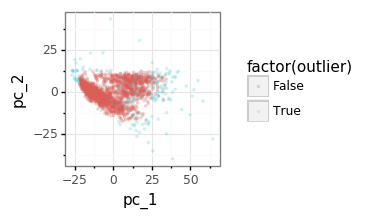

<ggplot: (8779420618504)>


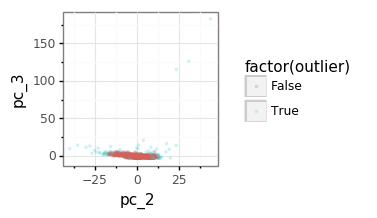

<ggplot: (8779420625549)>


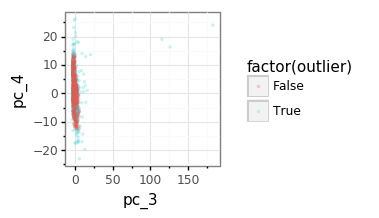

<ggplot: (-9223363257436429596)>


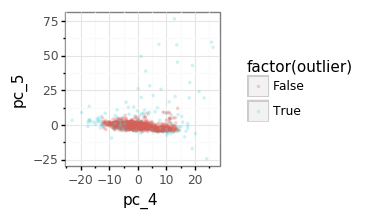

<ggplot: (-9223363257436371221)>


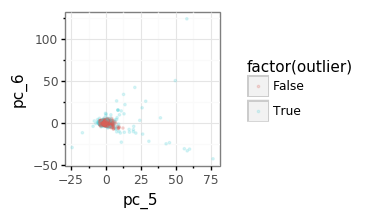

<ggplot: (-9223363257435965878)>


In [5]:
pca_df = pd.DataFrame(adata_subset2.obsm['X_pca'])
pca_df.columns = [f'pc_{int(x)+1}' for x in pca_df.columns]
pca_df['acral_subtype'] = adata_subset2.obs['acral_subtype'].values
pca_df['coi_id'] = adata_subset2.obs.index.values

omit_list = []
for pc_val in range(1,11,1):
    pca_df_slice = pca_df.loc[:,[f'pc_{pc_val}','coi_id']]
    qupper = pca_df_slice.quantile(0.99).values[0]
    qlower = pca_df_slice.quantile(0.01).values[0]
    omit_list = omit_list + pca_df_slice.query(f'pc_{pc_val} > {qupper}').coi_id.tolist()
    omit_list = omit_list + pca_df_slice.query(f'pc_{pc_val} < {qlower}').coi_id.tolist()
pca_df['outlier'] = [x in omit_list for x in pca_df['coi_id']]

plotnine.options.figure_size=(2,2)

for x in range(1,6,1):
    plot = (ggplot(pca_df)
            + theme_bw()
            + geom_point(aes(f'pc_{x}',f'pc_{x+1}',color='factor(outlier)'),
                         size=0.5, alpha = 0.2
                        )
           )
    print(plot)

In [6]:
n_pcs = 10
raw_adata.obs['recluster'] = [x in list(set(coi_list)-set(omit_list)) for x in raw_adata.obs.index]
adata_subset2 = raw_adata[raw_adata.obs['recluster'] == True]
adata_subset2 = sc.pp.log1p(adata_subset2, copy=True) # new
sc.pp.highly_variable_genes(adata_subset2,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(adata_subset2) # new
sc.tl.pca(adata_subset2,svd_solver='arpack', use_highly_variable = True, n_comps=n_pcs, random_state=1) # new
sc.pp.neighbors(adata_subset2, n_pcs=n_pcs, n_neighbors=100, random_state=1) # new
sc.tl.umap(adata_subset2, min_dist = 0.5, random_state=1, init_pos='random')
sc.tl.louvain(adata_subset2, resolution = 0.25, random_state=1)

# add feature labels
for input_adata in [adata_subset2]:
    input_adata.obs['true_year'] = [float(x.split('WK')[0])/52 if len(x.split('WK')[0]) <= 3 else np.nan for x in input_adata.obs.patient]
    input_adata.obs['true_year'] = [y+(9/12) if np.isnan(x) else x for x,y in zip(input_adata.obs['true_year'], input_adata.obs['age']) ]

    input_adata.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in input_adata.obs.age]
    input_adata.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in input_adata.obs.general_location]
    foll_idx = full_adata[[x in ['light_foll_mel','dark_foll_mel'] for x in full_adata.obs.class_2]].obs.index.tolist()
    input_adata.obs['subtypes'] = ['follicular' if x in foll_idx \
                                   else y for x,y in zip(input_adata.obs.index, input_adata.obs['subtypes'])]
    input_adata.obs['acral_subtype'] = [x if x == 'acral' else 'not_acral' for x in input_adata.obs['subtypes']]
    input_adata.obs['foreskin_subtype'] = [x if x == 'foreskin' else 'not_foreskin' for x in input_adata.obs['subtypes']]
    input_adata.obs['follicular_subtype'] = [x if x == 'follicular' else 'not_follicular' for x in input_adata.obs['subtypes']]

    input_adata.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(input_adata.obs.dev_stage, input_adata.obs.subtypes)]


    for i in ['dev_stage', 'subtypes', 'acral_subtype' ,'foreskin_subtype','follicular_subtype','dev_subtype']:
        input_adata.obs[i] =  (input_adata
                                 .obs[i]
                                 .astype(str)
                               .astype(CategoricalDtype(eval(f'{i}_order'), ordered = True))
                              )

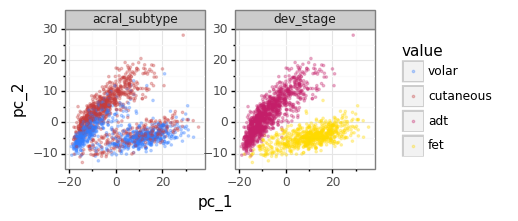

<ggplot: (8779412882461)>


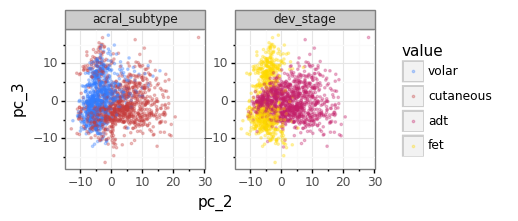

<ggplot: (8779418846959)>


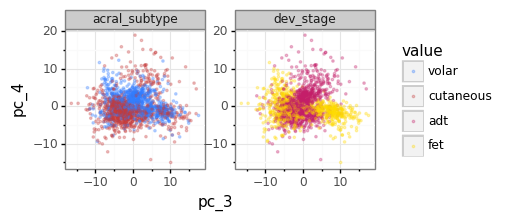

<ggplot: (-9223363257477613964)>


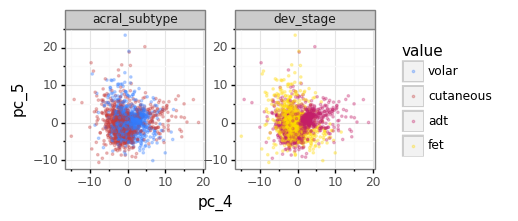

<ggplot: (-9223363257436280590)>


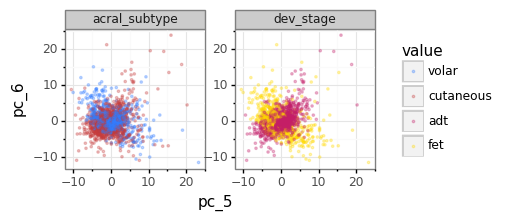

<ggplot: (-9223363257434036578)>


In [7]:
pca_df = pd.DataFrame(adata_subset2.obsm['X_pca'])
pca_df.columns = [f'pc_{int(x)+1}' for x in pca_df.columns]
pca_df['acral_subtype'] = adata_subset2.obs['acral_subtype'].values
pca_df['acral_subtype'] = pca_df['acral_subtype'].replace('not_acral', 'cutaneous').replace('acral','volar')
pca_df['dev_stage'] = adata_subset2.obs['dev_stage'].values

pca_df_melt = pd.melt(pca_df, id_vars=['pc_1','pc_2','pc_3','pc_4','pc_5','pc_6','pc_7','pc_8','pc_9','pc_10'])
pca_df_melt['value'] = (pca_df_melt['value']
                        .astype(str)
                        .astype(CategoricalDtype(['volar','cutaneous','adt','fet'],ordered=True))
                       )

plotnine.options.figure_size=(4,2)
for x in range(1,6,1):
    plot = (ggplot(pca_df_melt)
            + theme_bw()
            + theme(aspect_ratio=1,
                    panel_spacing=0.3
                   )
            + geom_point(aes(f'pc_{x}',f'pc_{x+1}',color='value'),
                         size=0.5, alpha = 0.3
                        )
            + facet_wrap('~variable', ncol=2, scales='free')
            + scale_color_manual(values = {'volar':'#337DFF',
                                           'cutaneous':'#C63C3C',
                                           'adt':'#C41E69',
                                           'fet':'#ffda00',
                
            })
           )
    print(plot)
    

## Melanocyte only PC space with HPGD  and NTRK expression overlay

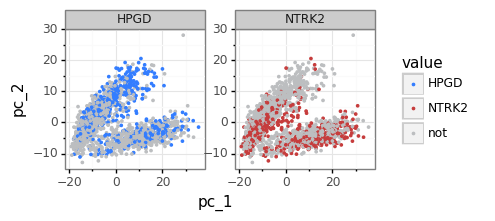

<ggplot: (8779418401060)>


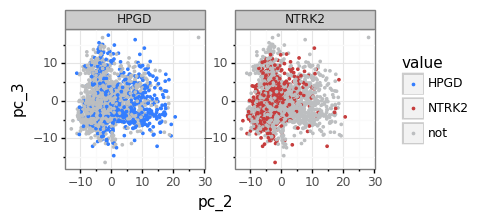

<ggplot: (-9223363257435768376)>


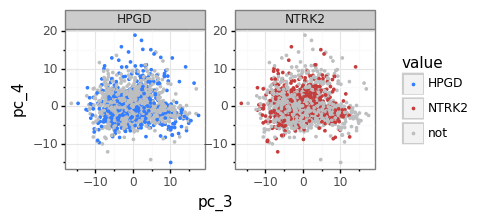

<ggplot: (-9223363257436102933)>


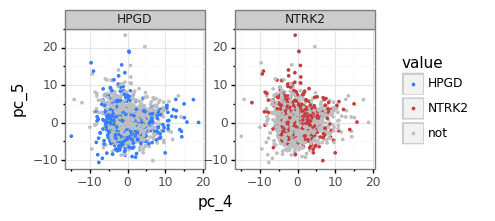

<ggplot: (8779418401053)>


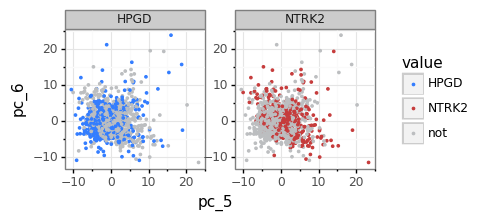

<ggplot: (8779418921718)>


In [8]:
_,df = prepare_dataframe(adata_subset2,adata_subset2.var_names,'cell')
pca_df = pd.DataFrame(adata_subset2.obsm['X_pca'])
pca_df.columns = [f'pc_{int(x)+1}' for x in pca_df.columns]
pca_df['NTRK2'] = ['NTRK2' if x > 0 else 'not' for x in df['NTRK2']]
pca_df['HPGD'] = ['HPGD' if x > 0 else 'not' for x in df['HPGD']]

pca_df_melt = pd.melt(pca_df, id_vars=['pc_1','pc_2','pc_3','pc_4','pc_5','pc_6','pc_7','pc_8','pc_9','pc_10'])

plotnine.options.figure_size=(4,2)
for x in range(1,6,1):
    plot = (ggplot(pca_df_melt)
            + theme_bw()
            + theme(aspect_ratio=1,
                    panel_spacing=0.3
                   )
            + geom_point(aes(f'pc_{x}',f'pc_{x+1}',color='value'),
                         size=0.5, alpha = 1
                        )
            + facet_wrap('~variable', ncol=2, scales='free')
            + scale_color_manual(values={'NTRK2':'#c63c3c',
                                         'HPGD':'#337dff',
                                         'not':'#bcbec0',
                                        })
           )
    print(plot)